In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.anova import anova_lm
from ISLP import load_data

# Simple Linear Regression

In [151]:
Boston = load_data("Boston")
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [152]:
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [153]:
X = pd.DataFrame(
    {
        "intercept": np.ones(Boston.shape[0]), 
        "lstat": Boston["lstat"]
    }
)

X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


In [154]:
y = Boston["medv"]
model = sm.OLS(y, X)
results = model.fit()

In [155]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           5.08e-88
Time:                        13:09:32   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.0

In [156]:
results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

In [157]:
X_test = pd.DataFrame({
    "intercept": np.ones(3), 
    "lstat": [5, 10, 15]
})
X_test

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [158]:
y_test = results.get_prediction(X_test)
y_test.predicted

array([29.80359411, 25.05334734, 20.30310057])

In [159]:
y_test.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

In [160]:
y_test.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

Plotting the regression line against the predictor and response

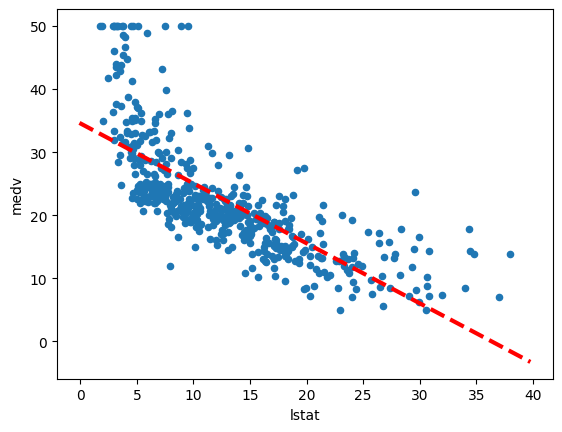

In [161]:
ax = Boston.plot.scatter("lstat", "medv")
b, m = results.params
xlim = ax.get_xlim()
ylim = [m * xlim[0] + b, m * xlim[1] + b]
ax.plot(xlim, ylim, "r--", linewidth=3)

Residual plot

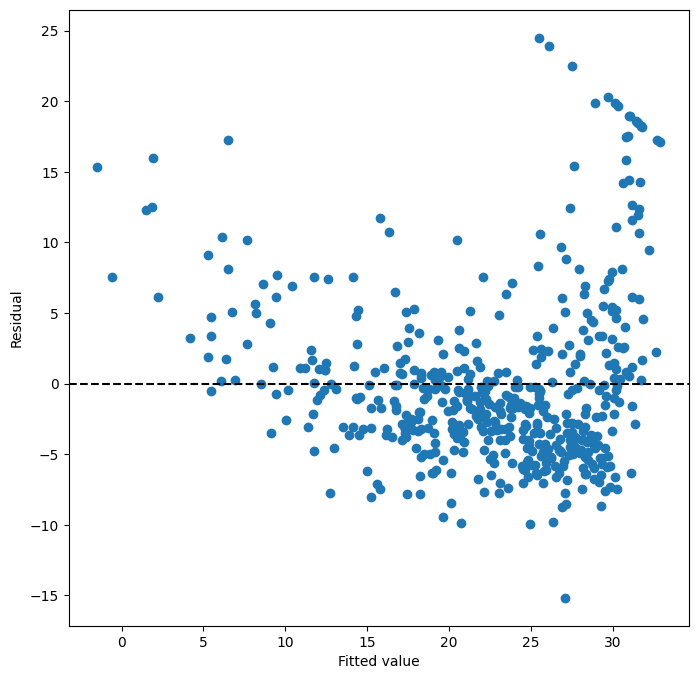

In [162]:
ax = plt.subplots(figsize=(8, 8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel("Fitted value")
ax.set_ylabel("Residual")
ax.axhline(0, c="k", ls="--")

Since the residual plot seems to have a slight curve, we take a look at the leverage of the data points. 

In order to check whether these points are actually high leverage points, we compute the average, and then identify which points have a leverage more than 3 times the average. 

In [163]:
influence = results.get_influence()
avg_leverage = influence.hat_matrix_diag.mean()

Data point with the highest leverage: 374


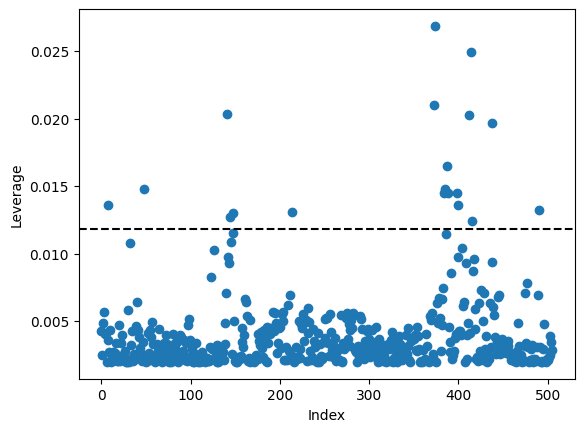

In [164]:
ax = plt.subplot()
ax.scatter(np.arange(X.shape[0]), influence.hat_matrix_diag)
ax.axhline(3 * avg_leverage, c="k", ls="--")
ax.set_xlabel("Index")
ax.set_ylabel("Leverage")
print(f"Data point with the highest leverage: {np.argmax(influence.hat_matrix_diag)}")

A better way to identify whether these high leverage points must be discarded is to plot the studentized residuals

Text(0, 0.5, 'Studentized Residuals')

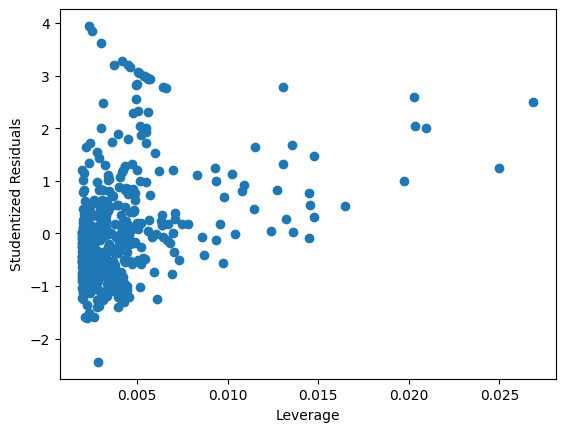

In [165]:
ax = plt.subplot()
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal)
ax.set_xlabel("Leverage")
ax.set_ylabel("Studentized Residuals")

In [166]:
high_leverage_index = influence.hat_matrix_diag > 3 * avg_leverage
high_resid_index = abs(influence.resid_studentized_internal) >= 2

combined = np.logical_and(high_leverage_index, high_resid_index)
discard_index = np.where(combined)[0]
discard_index

array([141, 214, 374, 412])

# Multiple Linear Regression

## Using only quantitative predictors

In [167]:
X = sm.add_constant(Boston[["lstat", "age"]])
y = Boston["medv"]
model1 = sm.OLS(y, X)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           2.98e-88
Time:                        13:09:34   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2228      0.731     45.458      0.0

In [168]:
X = sm.add_constant(Boston.drop(columns=["medv"])) 
y = Boston["medv"]
model = sm.OLS(y, X)
results = model.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           2.98e-88
Time:                        13:09:34   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2228      0.731     45.458      0.0

Checking for multicollinearity

In [169]:
vif_df = pd.DataFrame(
    {
        "vifs": [vif(X, i) for i in range(1, X.shape[1])]
    }, 
    index=X.columns[1:]
)
vif_df

,vifs
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


In [170]:
X.drop(columns="const").corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,0.455621
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,-0.053929
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,0.543993


"rad" and "tax" have a very high correlation (>0.91), and also have high VIFs. So, we can combine them to create a new predictor, rad_tax.

In [171]:
X["rad_tax"] = X["rad"] + X["tax"]
X = X.drop(columns=["rad", "tax"])
X.head()

,const,crim,zn,indus,chas,nox,rm,age,dis,ptratio,lstat,rad_tax
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,15.3,4.98,297
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,17.8,9.14,244
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,17.8,4.03,244
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,18.7,2.94,225
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,18.7,5.33,225


In [172]:
pd.DataFrame(
    {
        "vifs": [vif(X, i) for i in range(1, X.shape[1])]
    }, 
    index=X.columns[1:]
)

,vifs
crim,1.642000
zn,2.268386
indus,3.654979
chas,1.059037
nox,4.286206
rm,1.861322
age,3.069053
dis,3.953174
ptratio,1.742102
lstat,2.864672


In [173]:
X.drop(columns=["const"]).corr()

,crim,zn,indus,chas,nox,rm,age,dis,ptratio,lstat,rad_tax
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.289946,0.455621,0.587332
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.391679,-0.412995,-0.315762
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.383248,0.603800,0.717604
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.121515,-0.053929,-0.034345
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.188933,0.590879,0.668051
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.355501,-0.613808,-0.289225
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.261515,0.602339,0.506105
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.232471,-0.496996,-0.534721
ptratio,0.289946,-0.391679,0.383248,-0.121515,0.188933,-0.355501,0.261515,-0.232471,1.000000,0.374044,0.462990
lstat,0.455621,-0.412995,0.603800,-0.053929,0.590879,-0.613808,0.602339,-0.496996,0.374044,1.000000,0.543560


The variance inflation factors and correlations are now within the acceptable limits. 

Next, we think about including polynomial features in the model to account for a non-linear relationship between some of the predictors and the response. 

In addition, we also look at interaction terms for the predictors. Let us start with a simple case of using 2 predictors.

In [174]:
from sklearn.preprocessing import PolynomialFeatures

In [175]:
poly = PolynomialFeatures(degree=2, include_bias=False)
cols = ["lstat"]
X = pd.DataFrame(
    poly.fit_transform(Boston[cols]), 
    columns=poly.get_feature_names_out(cols)
)
X["age"] = Boston["age"]
X = sm.add_constant(X)
X.head()

,const,lstat,lstat^2,age
0,1.0,4.98,24.8004,65.2
1,1.0,9.14,83.5396,78.9
2,1.0,4.03,16.2409,61.1
3,1.0,2.94,8.6436,45.8
4,1.0,5.33,28.4089,54.2


In [176]:
y = Boston["medv"]
model2 = sm.OLS(y, X)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     337.3
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          7.03e-120
Time:                        13:09:35   Log-Likelihood:                -1561.0
No. Observations:                 506   AIC:                             3130.
Df Residuals:                     502   BIC:                             3147.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.2885      0.873     47.284      0.0

Comparing the results using Analysis of Variance:

In [177]:
print(anova_lm(results1, results2))

   df_resid           ssr  df_diff      ss_diff           F        Pr(>F)
0     503.0  19168.128609      0.0          NaN         NaN           NaN
1     502.0  14165.613251      1.0  5002.515357  177.278785  7.468491e-35


In the above comparison, results1 contains lstat and age, and results2 contains lstat, lstat^2, and age. 

Anova carries out a hypothesis test with the following hypotheses:
- $H_0$: Coefficient of $lstat^2 = 0$
- $H_1$: Coefficient of $lstat^2 \neq 0$

From the p-value of the $lstat^2$ feature and the lower SSR, we can say that the squared feature improves the fit.

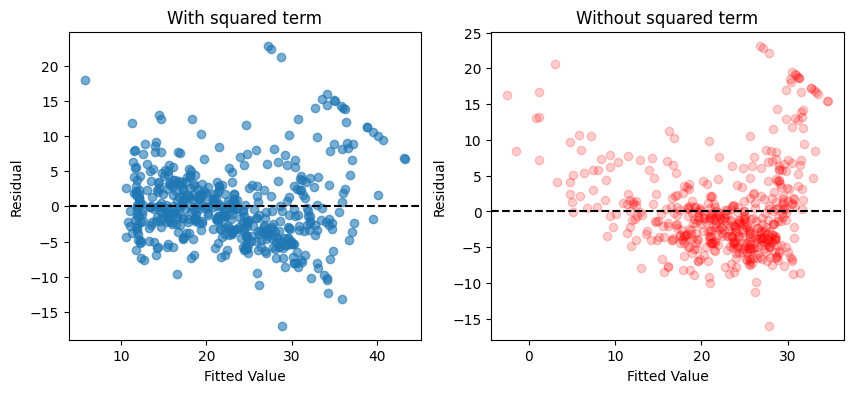

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(results2.fittedvalues, results2.resid, alpha=0.6)
ax[0].set_title("With squared term")
ax[0].set_xlabel("Fitted Value")
ax[0].set_ylabel("Residual")
ax[0].axhline(0, c='k', ls="--")

ax[1].scatter(results1.fittedvalues, results1.resid, c="r", alpha=0.2)
ax[1].set_title("Without squared term")
ax[1].set_xlabel("Fitted Value")
ax[1].set_ylabel("Residual")
ax[1].axhline(0, c='k', ls="--")

We see from the residual plots of the 2 models that the one with the squared term does not show any discernable pattern, while the one without it has a slight u-shaped curve. This provides additional evidence for including the squared term.

## Using qualitative predictors

In [179]:
Carseats = load_data("Carseats")
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [180]:
Carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    category
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    category
 10  US           400 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 26.7 KB


In [181]:
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [182]:
from sklearn.preprocessing import OneHotEncoder

In [183]:
X = pd.get_dummies(Carseats.drop(columns=["Sales"]), drop_first=True, dtype=int)
# Let us also include interaction terms for the (Income, Advertising) and (Price, Age) pairs
X["Income:Advertising"] = X["Income"] * X["Advertising"]
X["Price:Age"] = X["Price"] * X["Age"]
X = sm.add_constant(X)
y = Carseats["Sales"]

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          6.14e-166
Time:                        13:09:36   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.5756      1

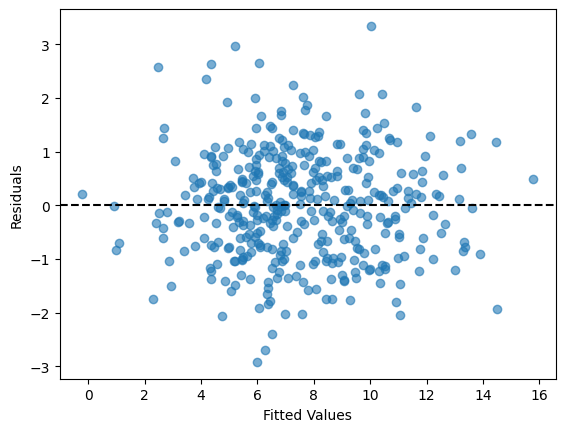

In [184]:
ax = plt.subplot()
ax.scatter(result.fittedvalues, result.resid, alpha=0.6)
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")
ax.axhline(0, c='k', ls="--")

In [185]:
vif_df = pd.DataFrame(
    {
        "vifs": [vif(X, i) for i in range(1, X.shape[1])]
    }, 
    index=X.columns[1:]
)
vif_df

,vifs
CompPrice,1.558078
Income,2.075502
Advertising,8.832228
Population,1.148225
Price,12.122329
Age,26.086178
Education,1.032010
ShelveLoc_Good,1.530982
ShelveLoc_Medium,1.534769
Urban_Yes,1.029099


In [186]:
import seaborn as sns

<Axes: >

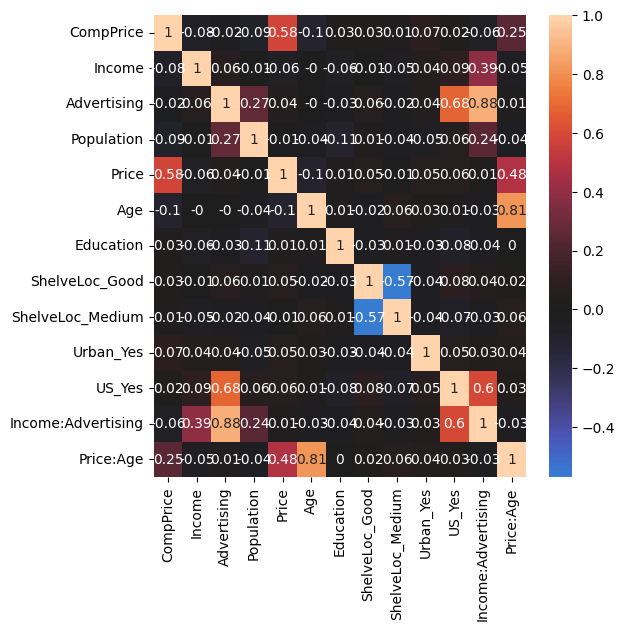

In [187]:
fig = plt.figure(figsize=(6, 6))
sns.heatmap(round(X.drop(columns=["const"]).corr(), 2), center=0, annot=True)

In [188]:
X = pd.get_dummies(Carseats.drop(columns=["Sales", "Population", "Education", "Urban", "US"]), drop_first=True, dtype=int)
# Let us include interaction terms for the (Income, Advertising) pair
X["Income:Advertising"] = X["Income"] * X["Advertising"]
# X["Price:Age"] = X["Price"] * X["Age"]
X = sm.add_constant(X)
y = Carseats["Sales"]

model1 = sm.OLS(y, X)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     340.7
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          4.87e-171
Time:                        13:09:37   Log-Likelihood:                -567.19
No. Observations:                 400   AIC:                             1152.
Df Residuals:                     391   BIC:                             1188.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.7253      0

In [189]:
vif_df = pd.DataFrame(
    {
        "vifs": [vif(X, i) for i in range(1, X.shape[1])]
    }, 
    index=X.columns[1:]
)
vif_df

,vifs
CompPrice,1.536280
Income,2.022959
Advertising,7.387554
Price,1.534807
Age,1.022483
ShelveLoc_Good,1.499077
ShelveLoc_Medium,1.499280
Income:Advertising,8.695282


<Axes: >

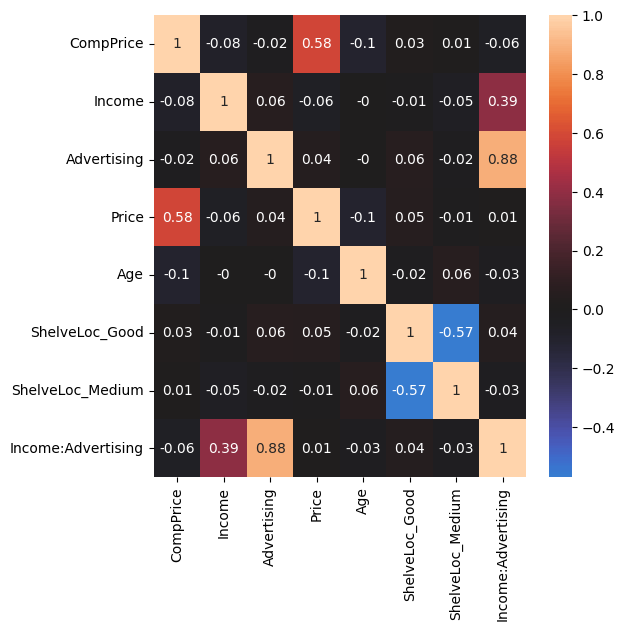

In [190]:
fig = plt.figure(figsize=(6, 6))
sns.heatmap(round(X.drop(columns=["const"]).corr(), 2), center=0, annot=True)

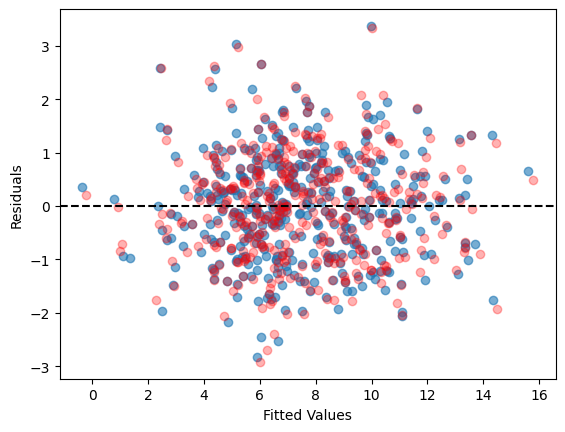

In [191]:
ax = plt.subplot()
ax.scatter(result1.fittedvalues, result1.resid, alpha=0.6)
ax.scatter(result.fittedvalues, result.resid, alpha=0.3, c="r")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")
ax.axhline(0, c='k', ls="--")

We see no discernable patterns in the residual plot, and the p-values of all the predictors are below 0.05. 

In [192]:
anova_lm(result, result1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,386.0,394.228988,0.0,NaN,NaN,NaN
1,391.0,399.222804,-5.0,-4.993816,0.978192,NaN


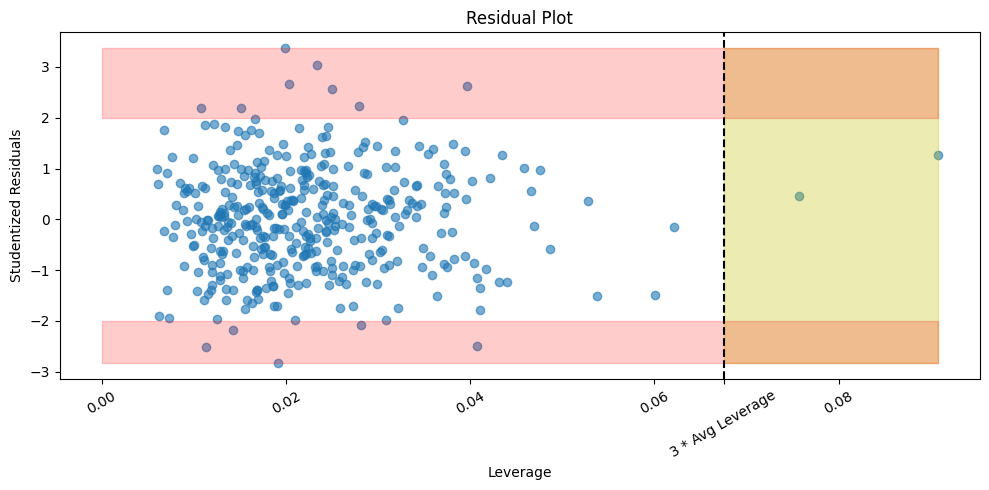

In [193]:
influence1 = result1.get_influence()
avg_leverage = influence1.hat_matrix_diag.mean()
max_leverage = influence1.hat_matrix_diag.max()
max_resid = influence1.resid_studentized_internal.max()
min_resid = influence1.resid_studentized_internal.min()

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.scatter(influence1.hat_matrix_diag, influence1.resid_studentized_internal, alpha=0.6)
ax.set_xlabel("Leverage")
ax.set_ylabel("Studentized Residuals")
ax.set_title("Residual Plot")

ax.axvline(3 * avg_leverage, c='k', ls="--")
ax.set_xticks(list(ax.get_xticks()) + [3 * avg_leverage], list(ax.get_xticklabels()) + ["3 * Avg Leverage"], rotation=30)

ax.fill_betweenx(y=np.linspace(min_resid, max_resid, 100), x1=3 * avg_leverage, x2=max_leverage, color='y', alpha=0.3)
ax.fill_between(x=np.linspace(0, max_leverage, 100), y1=min(2, max_resid), y2=max(2, max_resid), color='r', alpha=0.2)
ax.fill_between(x=np.linspace(0, max_leverage, 100), y1=max(-2, min_resid), y2=min(-2, min_resid), color='r', alpha=0.2)

plt.tight_layout()

Since non of the points have high-leverage and high-residuals, we need not discard any points.